# Model exploration - kaggle dataset

Since DAPS dataset is too easy for a Neural Network (hard to overfit, very high accuracy even with small subset of dataset), I move with the exploration to new dataset - [Tensorflow speech recognition](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview). Contains more classes and bigger dataset overall. Let's see how much can we learn from this dataset.

In [1]:
import os
import matplotlib.pyplot as plt
from keras.api.utils import image_dataset_from_directory
from keras.api.optimizers import SGD
from keras.api.losses import CategoricalCrossentropy
from keras.api.metrics import CategoricalAccuracy
from keras.api.callbacks import EarlyStopping
from keras.api.optimizers.schedules import ExponentialDecay
import numpy as np
import tensorflow as tf
import keras
from datetime import datetime

DATA_PATH = os.path.join(os.getcwd(), "..", "data")
LOG_DIR = os.path.join(os.getcwd(), "..", "logs")
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

2024-12-05 14:59:20.070546: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 14:59:20.082607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733407160.096760   16772 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733407160.100925   16772 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 14:59:20.115855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
dataset_path = os.path.join(DATA_PATH, "kaggle-speech-recognition")
batch_size = 128
class_names = next(os.walk(os.path.join(dataset_path, "train")))[1]

ds_train: tf.data.Dataset = image_dataset_from_directory(os.path.join(dataset_path, "train"), color_mode="grayscale",
                                        label_mode="categorical", batch_size=batch_size, class_names=class_names,
                                        seed=42, validation_split=0.0)
ds_valid: tf.data.Dataset  = image_dataset_from_directory(os.path.join(dataset_path, "validation"), color_mode="grayscale",
                                        label_mode="categorical", batch_size=batch_size, class_names=class_names,
                                        seed=42, validation_split=0.0)

ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

Found 51088 files belonging to 30 classes.


I0000 00:00:1733407171.911686   16772 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 6798 files belonging to 30 classes.


In [3]:
metrics = [CategoricalAccuracy()]

Let's get a closer look to a random sample from training dataset.

In [4]:
X, y = next(ds_train.as_numpy_iterator())
X.shape, y.shape

((128, 256, 256, 1), (128, 30))

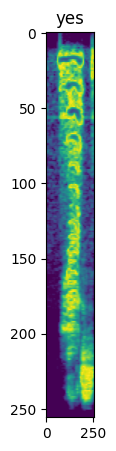

In [5]:
plt.figure(figsize=(10, 5))
plt.title(class_names[np.argmax(y[1])])
plt.imshow(X[1], aspect=8.0)

In [92]:
def simple_ann(input_shape = (256, 256)) -> keras.Model:
    inputs = keras.Input((*input_shape, 1), dtype=np.float32)
    x = keras.layers.Rescaling(scale=1./255)(inputs)
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    outputs = keras.layers.Dense(30, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="SimpleNN")
    return model


model = simple_ann()
model.summary()

Model: "SimpleNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,785,182 (64.03 MB)

 Trainable params: 16,785,182 (64.03 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
optimizer = SGD()
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition")
model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S-{model.name}"))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=50,
            callbacks=[tensorboard_cb])

Epoch 1/50


I0000 00:00:1732380441.279942    3142 service.cc:148] XLA service 0x7f55d0003880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732380441.280417    3142 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-23 17:47:21.353563: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732380441.433529    3142 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-23 17:47:22.585833: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_138', 188 bytes spill stores, 188 bytes spill loads

2024-11-23 17:47:23.203147: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_138

  13/1597 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.0217 - auc: 0.0332 - categorical_accuracy: 0.0217 - false_negatives: 220.5385 - false_positives: 76.9231 - loss: 8.6782 - true_negatives: 6419.0771 - true_positives: 3.4615               

I0000 00:00:1732380445.053284    3142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1590/1597 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0442 - auc: 0.0400 - categorical_accuracy: 0.0442 - false_negatives: 25452.0039 - false_positives: 92.8686 - loss: 3.5500 - true_negatives: 738131.1250 - true_positives: 3.9956

2024-11-23 17:47:40.067461: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_138_0', 208 bytes spill stores, 208 bytes spill loads



1597/1597 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0443 - auc: 0.0400 - categorical_accuracy: 0.0443 - false_negatives: 25563.9941 - false_positives: 92.8691 - loss: 3.5492 - true_negatives: 741378.8125 - true_positives: 3.9956

2024-11-23 17:47:45.013703: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_134_0', 232 bytes spill stores, 232 bytes spill loads



1597/1597 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.0443 - auc: 0.0400 - categorical_accuracy: 0.0443 - false_negatives: 25579.9648 - false_positives: 92.8692 - loss: 3.5491 - true_negatives: 741842.0000 - true_positives: 3.9956 - val_accuracy: 0.0933 - val_auc: 0.0713 - val_categorical_accuracy: 0.0933 - val_false_negatives: 6798.0000 - val_false_positives: 0.0000e+00 - val_loss: 3.2189 - val_true_negatives: 197142.0000 - val_true_positives: 0.0000e+00
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.0819 - auc: 0.0674 - categorical_accuracy: 0.0819 - false_negatives: 25583.0898 - false_positives: 0.6496 - loss: 3.2385 - true_negatives: 741934.1875 - true_positives: 0.8692 - val_accuracy: 0.0958 - val_auc: 0.0771 - val_categorical_accuracy: 0.0958 - val_false_negatives: 6798.0000 - val_false_positives: 0.0000e+00 - val_loss: 3.1786 - val_true_negatives: 197142.0000 - val_true_positives: 0.0000e+00
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - ac

No overfitting visible, but haven't achieved a ~90% accuracy first try with one hidden layer! Let's try
a bigger ann and see if it overfits.

In [6]:
def deep_ann(input_shape = (256, 256)) -> keras.Model:
    inputs = keras.Input((*input_shape, 1), dtype=np.float32)
    x = keras.layers.Rescaling(scale=1./255)(inputs)
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    outputs = keras.layers.Dense(30, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="DeepNN")
    return model

model = deep_ann()
model.summary()

optimizer = SGD()
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition")
model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S-{model.name}"))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=50,
            callbacks=[tensorboard_cb])

Model: "DeepNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │        15,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,095,646 (130.06 MB)

 Trainable params: 34,095,646 (130.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1732401644.659098   22777 service.cc:148] XLA service 0x7fd564008ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732401644.659923   22777 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-23 23:40:44.858294: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732401644.946042   22777 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-23 23:40:46.340152: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_138_0', 208 bytes spill stores, 208 bytes spill loads

2024-11-23 23:40:46.423112: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1

   7/1597 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.0327 - auc: 0.0327 - categorical_accuracy: 0.0327 - false_negatives: 128.0000 - false_positives: 0.0000e+00 - loss: 3.5808 - true_negatives: 3712.0000 - true_positives: 0.0000e+00         

I0000 00:00:1732401650.746370   22777 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1594/1597 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0734 - auc: 0.0632 - categorical_accuracy: 0.0734 - false_negatives: 25473.2227 - false_positives: 33.1543 - loss: 3.2860 - true_negatives: 740046.8750 - true_positives: 46.7773

2024-11-23 23:41:08.678730: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_138_0', 208 bytes spill stores, 208 bytes spill loads



1597/1597 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0735 - auc: 0.0632 - categorical_accuracy: 0.0735 - false_negatives: 25520.8770 - false_positives: 33.3757 - loss: 3.2857 - true_negatives: 741438.3125 - true_positives: 47.1121

2024-11-23 23:41:17.342647: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136_0', 232 bytes spill stores, 232 bytes spill loads



1597/1597 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.0735 - auc: 0.0632 - categorical_accuracy: 0.0735 - false_negatives: 25536.7363 - false_positives: 33.4493 - loss: 3.2856 - true_negatives: 741901.3750 - true_positives: 47.2240 - val_accuracy: 0.0940 - val_auc: 0.0846 - val_categorical_accuracy: 0.0940 - val_false_negatives: 6685.0000 - val_false_positives: 229.0000 - val_loss: 3.2767 - val_true_negatives: 196913.0000 - val_true_positives: 113.0000
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.1767 - auc: 0.1647 - categorical_accuracy: 0.1767 - false_negatives: 24980.0117 - false_positives: 357.8361 - loss: 2.8069 - true_negatives: 741577.0000 - true_positives: 603.9487 - val_accuracy: 0.1533 - val_auc: 0.1243 - val_categorical_accuracy: 0.1533 - val_false_negatives: 6433.0000 - val_false_positives: 585.0000 - val_loss: 3.3136 - val_true_negatives: 196557.0000 - val_true_positives: 365.0000
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accur

It does! No we can have fun with different architectures.

### CNN
Very simple cnn with 3 convolutional and pooling layers, dense layers at the end.

In [7]:
def simple_cnn(input_shape = (256, 256), batch_size = 32) -> keras.Model:
    inputs = keras.layers.Input(shape=input_shape, batch_size=batch_size)

    # Preprocessing
    x = keras.layers.Reshape((*input_shape, 1))(inputs)
    x = keras.layers.Rescaling(scale=1.0/255, offset=0.0)(x)

    # Convolution layers
    x = keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu")(x)
    x = keras.layers.MaxPool2D(pool_size=(3, 3))(x)

    x = keras.layers.Conv2D(64, kernel_size=(2, 2), activation="relu")(x)
    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = keras.layers.Conv2D(128, kernel_size=(2, 2), activation="relu")(x)
    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = keras.layers.AvgPool2D(pool_size=(2, 2))(x)

    # Dense layer
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    outputs = keras.layers.Dense(30, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="SimpleCNN")



simple_cnn().summary()
log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", "SimpleCNN")

learning_rates = np.logspace(-3, -2, 3)
models = []
early_stopping = EarlyStopping(patience=10, restore_best_weights=True, start_from_epoch=10)

for lr in learning_rates:
    model = simple_cnn()

    optimizer = SGD(learning_rate=lr)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S_lr-{lr}"))
    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=50,
                callbacks=[tensorboard_cb, early_stopping])

Model: "SimpleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (32, 256, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (32, 256, 256, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (32, 256, 256, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 84, 84, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 83, 83, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 41, 41, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 40, 40, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 20, 20, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (32, 10, 10, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 12800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 256)              │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 256)              │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 30)               │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,387,774 (12.92 MB)

 Trainable params: 3,387,774 (12.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1732460489.903043   18537 service.cc:148] XLA service 0x7f977800afb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732460489.903069   18537 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-24 16:01:29.947882: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732460490.024152   18537 cuda_dnn.cc:529] Loaded cuDNN version 90300


   4/1597 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - auc: 0.0323 - categorical_accuracy: 0.0495 - f1_score: 0.0238 - false_negatives: 80.0000 - false_positives: 0.0000e+00 - loss: 3.4019 - true_negatives: 2320.0000 - true_positives: 0.0000e+00 

I0000 00:00:1732460496.267377   18537 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1597/1597 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - auc: 0.0353 - categorical_accuracy: 0.0409 - f1_score: 0.0107 - false_negatives: 25583.9590 - false_positives: 0.0000e+00 - loss: 3.3981 - true_negatives: 741934.8125 - true_positives: 0.0000e+00 - val_auc: 0.0399 - val_categorical_accuracy: 0.0474 - val_f1_score: 0.0167 - val_false_negatives: 6798.0000 - val_false_positives: 0.0000e+00 - val_loss: 3.3869 - val_true_negatives: 197142.0000 - val_true_positives: 0.0000e+00
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - auc: 0.0394 - categorical_accuracy: 0.0519 - f1_score: 0.0196 - false_negatives: 25583.9590 - false_positives: 0.0000e+00 - loss: 3.3884 - true_negatives: 741934.8125 - true_positives: 0.0000e+00 - val_auc: 0.0442 - val_categorical_accuracy: 0.0713 - val_f1_score: 0.0336 - val_false_negatives: 6798.0000 - val_false_positives: 0.0000e+00 - val_loss: 3.3742 - val_true_negatives: 197142.0000 - val_true_positives: 0.0000e+00
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 34s

In [8]:
learning_rates = np.logspace(-1.5, -1, 2)

for lr in learning_rates:
    model = simple_cnn()

    optimizer = SGD(learning_rate=lr)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S_lr-{lr}"))
    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=50,
                callbacks=[tensorboard_cb, early_stopping])

Epoch 1/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - auc: 0.2908 - categorical_accuracy: 0.2623 - f1_score: 0.2738 - false_negatives: 27460.2305 - false_positives: 1689.2784 - loss: 3.2854 - true_negatives: 937387.5625 - true_positives: 4921.7290 - val_auc: 0.2594 - val_categorical_accuracy: 0.2661 - val_f1_score: 0.2478 - val_false_negatives: 6403.0000 - val_false_positives: 161.0000 - val_loss: 2.4677 - val_true_negatives: 196981.0000 - val_true_positives: 395.0000
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - auc: 0.3136 - categorical_accuracy: 0.3109 - f1_score: 0.3025 - false_negatives: 22547.4180 - false_positives: 1286.6221 - loss: 2.3401 - true_negatives: 740648.1875 - true_positives: 3036.5413 - val_auc: 0.4323 - val_categorical_accuracy: 0.4053 - val_f1_score: 0.4009 - val_false_negatives: 5246.0000 - val_false_positives: 673.0000 - val_loss: 1.9897 - val_true_negatives: 196469.0000 - val_true_positives: 1552.0000
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 36s

From above we can tell that higher learning rate is desirable for first few epochs but quickly becomes too big.
From now on we will train models with higher initial learning rate and apply exponential decay to it.

### Normalized input
Data is not normalized now, let's see how normalization will improve accuracy.

In [ ]:
def normalized_cnn(normalization_layer = None, input_shape = (256, 256), batch_size = 32) -> keras.Model:
    inputs = keras.layers.Input(shape=input_shape, batch_size=batch_size)

    # Preprocessing
    x = keras.layers.Reshape((*input_shape, 1))(inputs)
    if normalization_layer is not None:
        x = normalization_layer(x)

    # Convolution layers
    x = keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu")(x)
    x = keras.layers.MaxPool2D(pool_size=(3, 3))(x)

    x = keras.layers.Conv2D(64, kernel_size=(2, 2), activation="relu")(x)
    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = keras.layers.Conv2D(128, kernel_size=(2, 2), activation="relu")(x)
    x = keras.layers.AvgPool2D(pool_size=(2, 2))(x)

    # Dense layer
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    outputs = keras.layers.Dense(30, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="NormalizedCNN")



normalized_cnn().summary()

log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", "NormalizedCNN")
models = []

learning_rates = np.logspace(-2, -1, 3)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True, start_from_epoch=10)
normalization_layer = keras.layers.Normalization(axis=-1)
feature_ds = ds_train.map(lambda x, y: x)
normalization_layer.adapt(feature_ds)

for lr in learning_rates:
    model = normalized_cnn(normalization_layer)

    lr_scheduler = ExponentialDecay(lr, decay_steps=10_000, decay_rate=0.9)
    optimizer = SGD(learning_rate=lr_scheduler)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S_lr-{lr}"))
    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=50,
                callbacks=[tensorboard_cb, early_stopping])
    models.append((model, history))

Model: "NormalizedCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (32, 256, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (32, 256, 256, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (32, 254, 254, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (32, 84, 84, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (32, 83, 83, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (32, 41, 41, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (32, 40, 40, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (32, 20, 20, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (32, 51200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (32, 256)              │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (32, 256)              │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (32, 30)               │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,218,174 (50.42 MB)

 Trainable params: 13,218,174 (50.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2024-11-24 18:34:01.903879: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1732469642.171638   49245 service.cc:148] XLA service 0x7f40ac0196d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732469642.171730   49245 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-24 18:34:02.219106: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732469642.297611   49245 cuda_dnn.cc:529] Loaded cuDNN version 90300


   4/1597 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - categorical_accuracy: 0.0247 - loss: 3.4048  

I0000 00:00:1732469648.667617   49245 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1597/1597 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - categorical_accuracy: 0.0952 - loss: 3.2128 - val_categorical_accuracy: 0.2804 - val_loss: 2.4511
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - categorical_accuracy: 0.3667 - loss: 2.1646 - val_categorical_accuracy: 0.4550 - val_loss: 1.8390
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - categorical_accuracy: 0.5169 - loss: 1.6302 - val_categorical_accuracy: 0.5166 - val_loss: 1.6195
Epoch 4/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - categorical_accuracy: 0.6055 - loss: 1.3244 - val_categorical_accuracy: 0.5987 - val_loss: 1.3661
Epoch 5/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - categorical_accuracy: 0.6729 - loss: 1.1004 - val_categorical_accuracy: 0.5947 - val_loss: 1.4060
Epoch 6/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - categorical_accuracy: 0.7242 - loss: 0.9221 - val_categorical_accuracy: 0.6395 - val_loss: 1.2222
Epoch 7/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - categorical_accur

Normalization helped a lot with smoothing loss function, making it easier for optimizer to skip local minima.
Overfitting is hard, but we are going to take care of that later.

In [38]:
models[2][0].save("../models/NormalizedCNN.keras", zipped=True)

### Regularization

Since our model seems to be able to capture complexity of the data, we are going to regularize it to
and see if it generalizes better. After first and second Dense layer I put dropout with rate 0.7.


In [ ]:
def regularized_cnn(
        dropout_rate = 0.7,
        normalization_layer = None,
        input_shape = (256, 256),
        batch_size = 32
) -> keras.Model:
    inputs = keras.layers.Input(shape=input_shape, batch_size=batch_size)

    # Preprocessing
    x = keras.layers.Reshape((*input_shape, 1))(inputs)
    if normalization_layer is not None:
        x = normalization_layer(x)

    # Convolution layers
    x = keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu")(x)
    x = keras.layers.MaxPool2D(pool_size=(3, 3))(x)

    x = keras.layers.Conv2D(64, kernel_size=(2, 2), activation="relu")(x)
    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = keras.layers.Conv2D(128, kernel_size=(2, 2), activation="relu")(x)
    x = keras.layers.AvgPool2D(pool_size=(2, 2))(x)

    # Dense layer
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    outputs = keras.layers.Dense(30, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="RegularizedCNN")



regularized_cnn().summary()

log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", regularized_cnn().name)
models = []
learning_rates = np.logspace(-2, -1, 3)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True, start_from_epoch=10)
normalization_layer = keras.layers.Normalization(axis=-1)
feature_ds = ds_train.map(lambda x, y: x)
normalization_layer.adapt(feature_ds)

for lr in learning_rates:
    model = regularized_cnn(normalization_layer)

    lr_scheduler = ExponentialDecay(lr, decay_steps=10_000, decay_rate=0.9)
    optimizer = SGD(learning_rate=lr_scheduler)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S_lr-{lr}"))
    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=50,
                callbacks=[tensorboard_cb, early_stopping])
    models.append((model, history))

Model: "RegularizedCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (32, 256, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (32, 256, 256, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 84, 84, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 83, 83, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 41, 41, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 40, 40, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (32, 20, 20, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 51200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 256)              │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 256)              │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 30)               │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,218,174 (50.42 MB)

 Trainable params: 13,218,174 (50.42 MB)

 Non-trainable params: 0 (0.00 B)

Let's try smaller dropout rate, as 0.7 from AlexNet may be too strict for our smaller dataset.

Also I have tweaked decay_steps parameter in ExponentialDecay, now it's 5000, instead of 10000.

In [5]:
log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", regularized_cnn().name)
models = []
learning_rates = np.logspace(-2, -1, 3)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True, start_from_epoch=10)
normalization_layer = keras.layers.Normalization(axis=-1)
feature_ds = ds_train.map(lambda x, y: x)
normalization_layer.adapt(feature_ds)

for lr in learning_rates:
    model = regularized_cnn(dropout_rate=0.35, normalization_layer=normalization_layer)

    lr_scheduler = ExponentialDecay(lr, decay_steps=5_000, decay_rate=0.9)
    optimizer = SGD(learning_rate=lr_scheduler)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S_lr-{lr}_dropout-0.35"))
    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=50,
                callbacks=[tensorboard_cb, early_stopping])
    models.append((model, history))

Epoch 1/50


2024-11-25 12:56:49.319064: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1732535809.606476    4156 service.cc:148] XLA service 0x7f2ebc003e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732535809.606976    4156 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-25 12:56:49.656319: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732535809.735075    4156 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/1597 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - categorical_accuracy: 0.0291 - loss: 3.4135    

I0000 00:00:1732535815.226566    4156 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1597/1597 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - categorical_accuracy: 0.0573 - loss: 3.3497 - val_categorical_accuracy: 0.2030 - val_loss: 2.8263
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - categorical_accuracy: 0.1639 - loss: 2.9006 - val_categorical_accuracy: 0.3124 - val_loss: 2.3651
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - categorical_accuracy: 0.2536 - loss: 2.5318 - val_categorical_accuracy: 0.4141 - val_loss: 2.0139
Epoch 4/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - categorical_accuracy: 0.3298 - loss: 2.2427 - val_categorical_accuracy: 0.4900 - val_loss: 1.8244
Epoch 5/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - categorical_accuracy: 0.3900 - loss: 2.0206 - val_categorical_accuracy: 0.5427 - val_loss: 1.5774
Epoch 6/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - categorical_accuracy: 0.4441 - loss: 1.8424 - val_categorical_accuracy: 0.5738 - val_loss: 1.4691
Epoch 7/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - categorical_accur

It looks as model is overfitting even with regularization. Maybe training data is not sufficient to
model real distribution of the problem. Let's try adding random crop to augment the data. Moreover 
I'm going to increase dropout to 0.5 and lengthen patience in early stopping for longer training.

In [ ]:
def augment_regularized_cnn(
        normalization_layer = None,
        dropout_rate = 0.5,
        input_shape = (256, 256),
        batch_size = 32
) -> keras.Model:
    inputs = keras.layers.Input(shape=input_shape, batch_size=batch_size)

    # Preprocessing
    x = keras.layers.Reshape((*input_shape, 1))(inputs)
    if normalization_layer is not None:
        x = normalization_layer(x)
    x = keras.layers.RandomCrop(height=255, width=255)(x)

    # Convolution layers
    x = keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu")(x)
    # Batch normalization can be done like this
    # x = keras.layers.Conv2D(16, kernel_size=(3, 3))(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D(pool_size=(3, 3))(x)

    x = keras.layers.Conv2D(64, kernel_size=(2, 2), activation="relu")(x)
    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = keras.layers.Conv2D(128, kernel_size=(2, 2), activation="relu")(x)
    x = keras.layers.AvgPool2D(pool_size=(2, 2))(x)

    # Dense layer
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    outputs = keras.layers.Dense(30, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="AugmentedRegularizedCNN")



augment_regularized_cnn().summary()

log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", augment_regularized_cnn().name)
models = []
learning_rates = np.logspace(-2, -1, 3)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True, start_from_epoch=10)
normalization_layer = keras.layers.Normalization(axis=-1)
feature_ds = ds_train.map(lambda x, y: x)
normalization_layer.adapt(feature_ds)

for lr in learning_rates:
    model = augment_regularized_cnn(normalization_layer=normalization_layer)

    lr_scheduler = ExponentialDecay(lr, decay_steps=5_000, decay_rate=0.9)
    optimizer = SGD(learning_rate=lr_scheduler)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S_lr-{lr}"))
    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=50,
                callbacks=[tensorboard_cb, early_stopping])
    models.append((model, history))

Model: "AugmentedRegularizedCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (32, 256, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (32, 256, 256, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_crop (RandomCrop)        │ (32, 255, 255, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (32, 253, 253, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 84, 84, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (32, 83, 83, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 41, 41, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (32, 40, 40, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (32, 20, 20, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (32, 51200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 256)              │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 256)              │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (32, 30)               │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,218,174 (50.42 MB)

 Trainable params: 13,218,174 (50.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2024-11-25 14:29:24.288235: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1597/1597 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - categorical_accuracy: 0.2650 - loss: 3.3848 - val_categorical_accuracy: 0.1309 - val_loss: 3.1664
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - categorical_accuracy: 0.0958 - loss: 3.2007 - val_categorical_accuracy: 0.2221 - val_loss: 2.7690
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - categorical_accuracy: 0.1510 - loss: 2.9397 - val_categorical_accuracy: 0.3213 - val_loss: 2.4631
Epoch 4/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - categorical_accuracy: 0.2105 - loss: 2.6776 - val_categorical_accuracy: 0.3797 - val_loss: 2.2242
Epoch 5/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - categorical_accuracy: 0.2671 - loss: 2.4551 - val_categorical_accuracy: 0.4237 - val_loss: 2.0051
Epoch 6/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - categorical_accuracy: 0.3084 - loss: 2.2950 - val_categorical_accuracy: 0.4801 - val_loss: 1.8544
Epoch 7/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - categorical_accur

?? I don't understand what happened with biggest learning rate

In [11]:
model = augment_regularized_cnn(normalization_layer=normalization_layer)

lr_scheduler = ExponentialDecay(0.1, decay_steps=5_000, decay_rate=0.9)
optimizer = SGD(learning_rate=lr_scheduler)
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S_lr-{lr}"))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=50,
            callbacks=[tensorboard_cb, early_stopping])

Epoch 1/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - categorical_accuracy: 0.0544 - loss: 3.3243 - val_categorical_accuracy: 0.2240 - val_loss: 2.6671
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - categorical_accuracy: 0.2136 - loss: 2.6388 - val_categorical_accuracy: 0.4612 - val_loss: 1.8971
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - categorical_accuracy: 0.3531 - loss: 2.0955 - val_categorical_accuracy: 0.5646 - val_loss: 1.4071
Epoch 4/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - categorical_accuracy: 0.4978 - loss: 1.6076 - val_categorical_accuracy: 0.7015 - val_loss: 1.0037
Epoch 5/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - categorical_accuracy: 0.5909 - loss: 1.2923 - val_categorical_accuracy: 0.7307 - val_loss: 0.8926
Epoch 6/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - categorical_accuracy: 0.6608 - loss: 1.0714 - val_categorical_accuracy: 0.7664 - val_loss: 0.7560
Epoch 7/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - catego

### Momentum
We are going to try now fitting dataset with different optimizers. I'm going to train a model with:
1. SGD with momentum (normal, not nesterov)
2. Adam

We will see if momentum can help somehow. Moreover, droupout increased to 

In [ ]:
def MyAlexNet(
        normalization_layer = None,
        dropout_rate = 0.5,
        input_shape = (256, 256),
        batch_size = 32
) -> keras.Model:
    inputs = keras.layers.Input(shape=input_shape, batch_size=batch_size)

    # Preprocessing
    x = keras.layers.Reshape((*input_shape, 1))(inputs)
    if normalization_layer is not None:
        x = normalization_layer(x)
    x = keras.layers.RandomCrop(height=227, width=227)(x)

    # Convolutional layers
    # Instead of 11x11 stride 4 we are going to use subsequent 3x3 layers
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2)(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2)(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(x)

    x = keras.layers.Conv2D(128, kernel_size=(3, 3))(x)
    # x = keras.layers.Conv2D(256, kernel_size=(3, 3), padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(x)

    x = keras.layers.Conv2D(256, kernel_size=(2, 2), strides=2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(256, kernel_size=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    # x = keras.layers.Conv2D(256, kernel_size=(2, 2))(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((2, 2), strides=(2, 2))(x)


    # Dense layer
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    outputs = keras.layers.Dense(30, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="MyAlexNet")



MyAlexNet().summary()

log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", MyAlexNet().name)
models = []

optimizers = [SGD(learning_rate=0.01, momentum=0.9)]
early_stopping = EarlyStopping(patience=25, restore_best_weights=True, start_from_epoch=10)
normalization_layer = keras.layers.Normalization(axis=-1)
feature_ds = ds_train.map(lambda x, y: x)
normalization_layer.adapt(feature_ds)

for optimizer in optimizers:
    model = MyAlexNet(normalization_layer=normalization_layer)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=[CategoricalAccuracy(name="categorical_accuracy")])

    model_log_dir = os.path.join(log_dir, f"opt-{optimizer.name}_lr={0.01}_momentum-{0.9}")
    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=50,
                callbacks=[tensorboard_cb, early_stopping])
    models.append((model, history))

Model: "MyAlexNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (32, 256, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (32, 256, 256, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_crop_2 (RandomCrop)      │ (32, 227, 227, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 113, 113, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 56, 56, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 54, 54, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (32, 54, 54, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (32, 54, 54, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 26, 26, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 24, 24, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (32, 24, 24, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (32, 24, 24, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 11, 11, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 5, 5, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (32, 5, 5, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (32, 5, 5, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (32, 4, 4, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (32, 4, 4, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 2, 2, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 256)              │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 256)              │             

 Total params: 1,176,734 (4.49 MB)

 Trainable params: 1,175,198 (4.48 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/50


2024-11-28 12:58:19.635431: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1732795101.335141    1362 cuda_dnn.cc:529] Loaded cuDNN version 90300


1597/1597 ━━━━━━━━━━━━━━━━━━━━ 100s 60ms/step - categorical_accuracy: 0.0407 - loss: 3.4310 - val_categorical_accuracy: 0.0482 - val_loss: 3.3462
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 95s 60ms/step - categorical_accuracy: 0.0483 - loss: 3.3581 - val_categorical_accuracy: 0.0565 - val_loss: 3.3486
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 98s 61ms/step - categorical_accuracy: 0.0736 - loss: 3.2237 - val_categorical_accuracy: 0.0763 - val_loss: 3.1292
Epoch 4/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 98s 61ms/step - categorical_accuracy: 0.0958 - loss: 3.0536 - val_categorical_accuracy: 0.1475 - val_loss: 2.8220
Epoch 5/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 96s 60ms/step - categorical_accuracy: 0.1448 - loss: 2.8283 - val_categorical_accuracy: 0.2284 - val_loss: 2.6245
Epoch 6/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 99s 62ms/step - categorical_accuracy: 0.2317 - loss: 2.5048 - val_categorical_accuracy: 0.2451 - val_loss: 2.4202
Epoch 7/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 99s 62ms/step - categorical_accu

In [8]:
model.save("../models/MyAlexNet.keras", zipped=True)

SGD with momentum and exponential decay.

In [9]:
log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", MyAlexNet().name)
models = []

early_stopping = EarlyStopping(patience=25, restore_best_weights=True, start_from_epoch=10)
normalization_layer = keras.layers.Normalization(axis=-1)
feature_ds = ds_train.map(lambda x, y: x)
normalization_layer.adapt(feature_ds)
learning_rates = np.logspace(-3, -1, 3)

for lr in learning_rates:
    model = MyAlexNet(normalization_layer=normalization_layer)
    lr_scheduler = ExponentialDecay(lr, decay_steps=10_000, decay_rate=0.9)
    optimizer = SGD(learning_rate=lr_scheduler, momentum=0.9)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=[CategoricalAccuracy(name="categorical_accuracy")])

    model_log_dir = os.path.join(log_dir, f"opt-{optimizer.name}_exp_decay_lr={lr}_steps-{10_000}_rate-{0.9}_momentum-{0.9}")
    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=100,
                callbacks=[tensorboard_cb, early_stopping])
    models.append((model, history))

Epoch 1/100


2024-11-28 14:35:02.776640: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1597/1597 ━━━━━━━━━━━━━━━━━━━━ 96s 59ms/step - categorical_accuracy: 0.0432 - loss: 3.4934 - val_categorical_accuracy: 0.1114 - val_loss: 3.2755
Epoch 2/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - categorical_accuracy: 0.0847 - loss: 3.2523 - val_categorical_accuracy: 0.1720 - val_loss: 2.9443
Epoch 3/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 96s 60ms/step - categorical_accuracy: 0.1739 - loss: 2.8228 - val_categorical_accuracy: 0.3358 - val_loss: 2.2859
Epoch 4/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 99s 62ms/step - categorical_accuracy: 0.3157 - loss: 2.2591 - val_categorical_accuracy: 0.4875 - val_loss: 1.7904
Epoch 5/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 101s 63ms/step - categorical_accuracy: 0.4261 - loss: 1.8737 - val_categorical_accuracy: 0.5643 - val_loss: 1.4597
Epoch 6/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 101s 63ms/step - categorical_accuracy: 0.4976 - loss: 1.6333 - val_categorical_accuracy: 0.6039 - val_loss: 1.3258
Epoch 7/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 97s 61ms/step - categoric

In [12]:
models[0][0].save("../models/MyAlexNet_opt-SGD_exp_decay_lr-0.001_steps-10000_rate-0.9_momentum-0.9.keras", zipped=True)

In [6]:
def residual_block(inputs, filters: int, kernel_size = (3, 3)) -> keras.layers.Layer:
    x = keras.layers.Conv2D(filters, kernel_size, padding="same")(inputs)

    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    if inputs.shape != x.shape:
        inputs = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding="same")(inputs)

    x = keras.layers.Add()([x, inputs])
    x = keras.layers.ReLU()(x)

    return x


def MyResNet(input_shape = (256, 256, 1), batch_size = 32, normalization_layer = None, ann_tail = False):
    inputs = keras.Input(shape=input_shape, batch_size=batch_size)

    # Normalization
    if normalization_layer is None:
        x = keras.layers.Rescaling(1.0/255.0, 0)(inputs)
    else:
        x = normalization_layer(inputs)

    x = keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # Residual blocks
    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)

    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)

    x = keras.layers.GlobalAvgPool2D(data_format="channels_last")(x)

    # Tail
    if ann_tail:
        x = keras.layers.Dense(256, activation="relu")(x)
        x = keras.layers.Dropout(0.5)(x)
        x = keras.layers.Dense(256, activation="relu")(x)
        x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Dense(30)(x)
    outputs = keras.layers.Softmax()(x)
    return keras.Model(inputs=inputs, outputs=outputs, name="MyResNet")

MyResNet().summary()

Model: "MyResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (32, 256, 256, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (32, 256, 256, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (32, 125, 125,    │      3,200 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (32, 125, 125,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (32, 125, 125,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (32, 62, 62, 64)  │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (32, 62, 62, 64)  │     36,928 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (32, 62, 62, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (32, 62, 62, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (32, 62, 62, 64)  │     36,928 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (32, 62, 62, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (32, 62, 62, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (32, 62, 62, 64)  │          0 │ re_lu_2[0][0],    │
│                     │                   │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (32, 62, 62, 64)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (32, 62, 62, 64)  │     36,928 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (32, 62, 62, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (32, 62, 62, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (32, 62, 62, 64)  │     36,928 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (32, 62, 62, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,789,406 (10.64 MB)

 Trainable params: 2,785,694 (10.63 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [7]:
log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", MyResNet().name)
models = []

early_stopping = EarlyStopping(patience=15, restore_best_weights=True, start_from_epoch=10)
normalization_layer = keras.layers.Normalization(axis=-1)
feature_ds = ds_train.map(lambda x, y: x)
normalization_layer.adapt(feature_ds)
learning_rates = np.logspace(-3, -1, 3)[::-1]
print(learning_rates)

for lr in learning_rates:
    model = MyResNet(batch_size=batch_size, normalization_layer=normalization_layer)
    lr_scheduler = ExponentialDecay(lr, decay_steps=10_000, decay_rate=0.9)
    optimizer = SGD(learning_rate=lr_scheduler, momentum=0.9)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=[CategoricalAccuracy(name="categorical_accuracy")])

    model_log_dir = os.path.join(log_dir, f"opt-{optimizer.name}_exp_decay_lr={lr}_steps-{10_000}_rate-{0.9}_momentum-{0.9}")
    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    history = model.fit(x=ds_train, validation_data=ds_valid, batch_size=batch_size, epochs=75,
                callbacks=[tensorboard_cb, early_stopping])
    models.append((model, history))

[0.1   0.01  0.001]
Epoch 1/75


2024-12-05 15:00:53.449432: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1733407256.426849   16900 service.cc:148] XLA service 0x7f64e800a0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733407256.427575   16900 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-05 15:00:56.566373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733407256.861357   16900 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-05 15:00:57.359527: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1904', 16 bytes spill stores, 16 bytes spill loads

2024-12-05 15:00:57.992478: I exte

400/400 ━━━━━━━━━━━━━━━━━━━━ 116s 233ms/step - categorical_accuracy: 0.0352 - loss: 4.1589 - val_categorical_accuracy: 0.0377 - val_loss: 3.3893
Epoch 2/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 88s 219ms/step - categorical_accuracy: 0.0358 - loss: 3.3960 - val_categorical_accuracy: 0.0377 - val_loss: 3.3890
Epoch 3/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 87s 219ms/step - categorical_accuracy: 0.0350 - loss: 3.3960 - val_categorical_accuracy: 0.0377 - val_loss: 3.3888
Epoch 4/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 92s 230ms/step - categorical_accuracy: 0.0355 - loss: 3.3956 - val_categorical_accuracy: 0.0377 - val_loss: 3.3893
Epoch 5/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 89s 223ms/step - categorical_accuracy: 0.0354 - loss: 3.3956 - val_categorical_accuracy: 0.0377 - val_loss: 3.3890
Epoch 6/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 93s 232ms/step - categorical_accuracy: 0.0353 - loss: 3.3956 - val_categorical_accuracy: 0.0377 - val_loss: 3.3893
Epoch 7/75
400/400 ━━━━━━━━━━━━━━━━━━━━ 90s 224ms/step - categorical_accuracy: 0